In [1]:
# auto reload changes ipynb
# auto reload
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/home/calvin/code/cmpnn_revised")

In [2]:
from cmpnn.data.molecule_data import MoleculeData
from cmpnn.featurizer.molecule_dataset import MoleculeDataset
from cmpnn.featurizer.atom_bond import AtomFeaturizer, BondFeaturizer
from cmpnn.featurizer.global_feat import CompositeGlobalFeaturizer, MorganBinaryFeaturizer, RDKit2DNormalizedFeaturizer

In [3]:
csv_file = "/home/calvin/code/cmpnn/data/molecule_data/mol.csv"



In [11]:
dataset = MoleculeDataset(
    csv_file=csv_file,
    smiles_col="smiles",
    target_cols=["target"],
    atom_featurizer=AtomFeaturizer(v2=False),
    bond_featurizer=BondFeaturizer(),
    global_featurizer= CompositeGlobalFeaturizer(
        featurizers=[
            MorganBinaryFeaturizer(radius=4, length=2048),
            RDKit2DNormalizedFeaturizer()
        ]
    ),
    atom_messages=True,
    use_cache=False)

Using all atomic numbers from 1 to 100
Processing data from /home/calvin/code/cmpnn/data/molecule_data/mol.csv


In [12]:
dataset

MoleculeDataset(100)

In [13]:
dataset[0]

MoleculeData(f_atoms=[24, 133], f_bonds=[54, 14], a2b=[24], b2a=[54], a_scope=[1], b_scope=[1], global_features=[2248], y=[1], bonds=[27, 2], smiles='Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14', b2revb=[54])

In [14]:
from cmpnn.data.molecule_data import MoleculeDataBatch

batch = MoleculeDataBatch.from_data_list(dataset)

[from_data_list] Init: 0.0088s | Loop: 0.0447s | Finalize: 0.0081s | Total: 0.0616s


In [15]:
import torch
batch = batch.to(device="cuda:0")
print({k: v.device for k, v in batch.items() if isinstance(v, torch.Tensor)})


{'f_atoms': device(type='cuda', index=0), 'f_bonds': device(type='cuda', index=0), 'a2b': device(type='cuda', index=0), 'b2a': device(type='cuda', index=0), 'b2revb': device(type='cuda', index=0), 'bonds': device(type='cuda', index=0), 'global_features': device(type='cuda', index=0), 'y': device(type='cuda', index=0)}


In [18]:
from cmpnn.split.scaffold import ScaffoldSplitter

In [19]:
splitter = ScaffoldSplitter(seed=42)

In [22]:
train_idx, val_idx, test_idx = splitter.split(dataset, train_frac=0.8, test_frac=0.1, val_frac=0.1, return_indices=True)
train_set, val_set, test_set = dataset[train_idx], dataset[val_idx], dataset[test_idx]

In [23]:
len(train_set), len(val_set), len(test_set)

(80, 10, 10)

INFO:scaffold:Label mean/std/count per split (max 3 splits, 1 labels):
INFO:scaffold:Split 0: mean=[2.14625], std=[1.349138], count=[80]
INFO:scaffold:Split 1: mean=[1.491], std=[0.9943183], count=[10]
INFO:scaffold:Split 2: mean=[2.382], std=[1.1866659], count=[10]


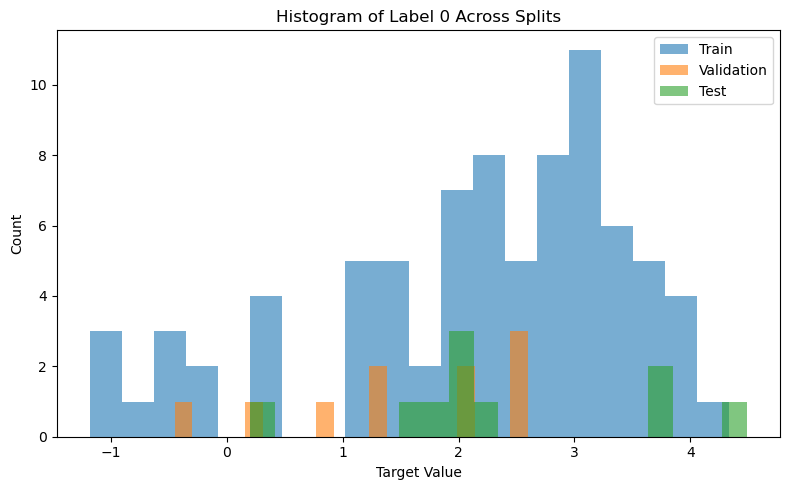

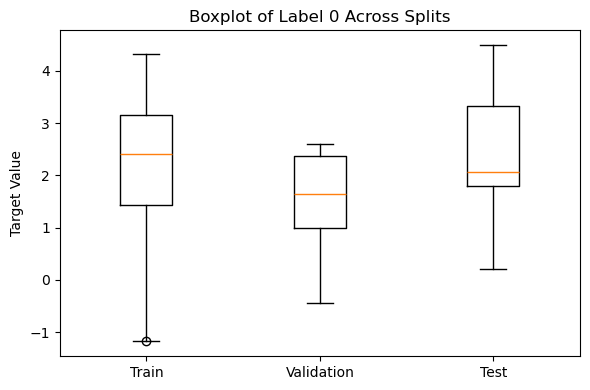

In [25]:
from cmpnn.split.utils import log_scaffold_stats, plot_split_distributions
import logging
# Set up logging
logging.basicConfig(level=logging.INFO)

log_scaffold_stats(
    data=dataset,
    index_sets=[set(train_idx), set(val_idx), set(test_idx)],
    num_scaffolds=3,
    num_labels=1,
    logger=logging.getLogger("scaffold")


)

plot_split_distributions(
    dataset=dataset,
    index_sets=[set(train_idx), set(val_idx), set(test_idx)],
    label_index=0
)

In [26]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=MoleculeDataBatch.from_data_list, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, collate_fn=MoleculeDataBatch.from_data_list, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, collate_fn=MoleculeDataBatch.from_data_list, num_workers=4, pin_memory=True)

In [27]:
import time
batch = next(iter(train_loader))
start = time.time()
batch.to("cuda")
print(f"Transfer time: {time.time() - start:.4f} sec")

[from_data_list] Init: 0.0005s | Loop: 0.0110s | Finalize: 0.0017s | Total: 0.0131s
[from_data_list] Init: 0.0005s | Loop: 0.0184s | Finalize: 0.0030s | Total: 0.0219s
[from_data_list] Init: 0.0007s | Loop: 0.0320s | Finalize: 0.0038s | Total: 0.0365s
Transfer time: 0.0005 sec


In [28]:
mol_list = [train_set[i] for i in range(32)]
import time
start = time.time()
batch = MoleculeDataBatch.from_data_list(mol_list)
print(f"Batch build time: {time.time() - start:.4f} sec")


[from_data_list] Init: 0.0003s | Loop: 0.0164s | Finalize: 0.0025s | Total: 0.0191s
Batch build time: 0.0198 sec


In [32]:
from cmpnn.models.lightning import CMPNNLightningModuleTimed, CMPNNLightningModule
from cmpnn.optimizer.noam import NoamLikeOptimizer


model = CMPNNLightningModule(
    atom_fdim=133,
    bond_fdim=14,
    atom_messages=True,
    global_fdim=2248,
    learning_rate=0.01,
    hidden_dim=256,
    booster='attention',
    comm_mode='mlp',
    optimizer_class=NoamLikeOptimizer,
    optimizer_params={
        'init_lr': 1e-4,
        'max_lr': 1e-3,
        'final_lr': 1e-5,
        'warmup_steps': 1000,
        'total_steps': 10000,
    }
)
print(model)

import pytorch_lightning as pl

trainer = pl.Trainer(
    max_epochs=2,
    accelerator="gpu",
    devices=1,
    logger=False,
    enable_progress_bar=True,
    precision="16-mixed",
    val_check_interval=0.5,
    # profiler="simple",
    accumulate_grad_batches=2
)

trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('AMD Radeon RX 6600') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/cal

CMPNNLightningModule(
  (model): CMPNNEncoder(
    comm_mode=mlp, booster=attention
      (dropout_layer): Dropout(p=0.1, inplace=False)
      (act_func): ReLU()
      (W_i_atom): Linear(in_features=133, out_features=256, bias=False)
      (W_i_bond): Linear(in_features=14, out_features=256, bias=False)
      (W_o): Linear(in_features=512, out_features=256, bias=False)
      (lr): Linear(in_features=768, out_features=256, bias=False)
      (gru): BatchGRU(
        (gru): GRU(256, 256, batch_first=True, bidirectional=True)
      )
      (atom_mlp): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): ReLU()
      )
      (W_h): ModuleList(
        (0-1): 2 x Linear(in_features=256, out_features=256, bias=False)
      )
    )
  (aggregator): MeanAggregator()
  (bn): Identity()
  (ffn): MLP(input_dim=2504, output_dim=1, hidden_dim=256, n_layers=1, dropout=0.1)
  (metrics): ModuleDict(
    (RMSE): MeanSquaredError()
    (MAE): MeanAbsoluteError()
    (

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

[from_data_list] Init: 0.0004s | Loop: 0.0048s | Finalize: 0.0010s | Total: 0.0063s


/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:310.)
  return F.linear(input, self.weight, self.bias)


[from_data_list] Init: 0.0004s | Loop: 0.0078s | Finalize: 0.0015s | Total: 0.0097s


Training: |          | 0/? [00:00<?, ?it/s]

[from_data_list] Init: 0.0006s | Loop: 0.0196s | Finalize: 0.0028s | Total: 0.0230s
[from_data_list] Init: 0.0005s | Loop: 0.0201s | Finalize: 0.0029s | Total: 0.0235s
[from_data_list] Init: 0.0004s | Loop: 0.0056s | Finalize: 0.0011s | Total: 0.0072s


Validation: |          | 0/? [00:00<?, ?it/s]

[from_data_list] Init: 0.0005s | Loop: 0.0055s | Finalize: 0.0011s | Total: 0.0070s


Validation: |          | 0/? [00:00<?, ?it/s]

[from_data_list] Init: 0.0005s | Loop: 0.0057s | Finalize: 0.0012s | Total: 0.0073s


Validation: |          | 0/? [00:00<?, ?it/s]

[from_data_list] Init: 0.0007s | Loop: 0.0155s | Finalize: 0.0017s | Total: 0.0179s
[from_data_list] Init: 0.0007s | Loop: 0.0204s | Finalize: 0.0030s | Total: 0.0240s
[from_data_list] Init: 0.0007s | Loop: 0.0214s | Finalize: 0.0030s | Total: 0.0251s
[from_data_list] Init: 0.0006s | Loop: 0.0073s | Finalize: 0.0012s | Total: 0.0091s


Validation: |          | 0/? [00:00<?, ?it/s]

[from_data_list] Init: 0.0006s | Loop: 0.0088s | Finalize: 0.0012s | Total: 0.0105s


Validation: |          | 0/? [00:00<?, ?it/s]

[from_data_list] Init: 0.0007s | Loop: 0.0150s | Finalize: 0.0012s | Total: 0.0169s


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [30]:
trainer.test(
    model,
    dataloaders=test_loader
)

NameError: name 'trainer' is not defined

In [ ]:
from cmpnn.crossval.crossvalidator import CrossValidator

from torch.utils.data import random_split
import torch
total_len = len(dataset)
test_len = int(0.1 * total_len)
train_val_len = total_len - test_len

train_val_data, test_data = random_split(dataset, [train_val_len, test_len], generator=torch.Generator().manual_seed(42))


model_fn = lambda: CMPNNLightningModule(
    atom_fdim=133,
    bond_fdim=14,
    atom_messages=True,
    global_fdim=2248,
    learning_rate=0.001,
)

trainer_fn = lambda: pl.Trainer(
    max_epochs=10,
    accelerator="gpu",
    devices=1,
    logger=False,
    enable_progress_bar=True,
    val_check_interval=0.5,
)

cross_validator = CrossValidator(
    dataset=train_val_data,
    model_fn = model_fn,
    trainer_fn=trainer_fn,
    splitter=splitter,
    k=5,
    test_set=test_data,)

In [ ]:
cross_validator.run()

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/calvin/code/cmpnn_revised/cmpnn/featurizer/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | model   | CMPNNEncoder | 331 K  | train
1 | bn      | Identity     | 0      | train
2 | ffn     | MLP          | 304 K  |

Running Fold 1/5


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    1.7159020900726318     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | model   | CMPNNEncoder | 331 K  | train
1 | bn      | Identity     | 0      | train
2 | ffn     | MLP          | 304 K  | train
3 | metrics | ModuleDict   | 0      | train
-------------------------------------------------
636 K     Trainable params
0         Non-trainable params
636 K     Total params
2.545     Total estimated model params size (MB

Running Fold 2/5


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    1.9170867204666138     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | model   | CMPNNEncoder | 331 K  | train
1 | bn      | Identity     | 0      | train
2 | ffn     | MLP          | 304 K  | train
3 | metrics | ModuleDict   | 0      | train
-------------------------------------------------
636 K     Trainable params
0         Non-trainable params
636 K     Total params
2.545     Total estimated model params size (MB

Running Fold 3/5


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    1.8565809726715088     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | model   | CMPNNEncoder | 331 K  | train
1 | bn      | Identity     | 0      | train
2 | ffn     | MLP          | 304 K  | train
3 | metrics | ModuleDict   | 0      | train
-------------------------------------------------
636 K     Trainable params
0         Non-trainable params
636 K     Total params
2.545     Total estimated model params size (MB

Running Fold 4/5


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     1.845572590827942     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | model   | CMPNNEncoder | 331 K  | train
1 | bn      | Identity     | 0      | train
2 | ffn     | MLP          | 304 K  | train
3 | metrics | ModuleDict   | 0      | train
-------------------------------------------------
636 K     Trainable params
0         Non-trainable params
636 K     Total params
2.545     Total estimated model params size (MB

Running Fold 5/5


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.8358371257781982     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | model   | CMPNNEncoder | 331 K  | train
1 | bn      | Identity     | 0      | train
2 | ffn     | MLP          | 304 K  | train
3 | metrics | M

Cross-validation finished. Aggregating results...
val_loss: mean=1.6342, std=0.4523
Retraining on full dataset and evaluating on held-out test set...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            MAE            │    1.0870052576065063     │
│            R2             │    -0.8960943222045898    │
│           RMSE            │    1.3184735774993896     │
└───────────────────────────┴───────────────────────────┘

Held-out test metrics: {'RMSE': 1.3184735774993896, 'MAE': 1.0870052576065063, 'R2': -0.8960943222045898}


[{'val_loss': 1.7159020900726318},
 {'val_loss': 1.9170867204666138},
 {'val_loss': 1.8565809726715088},
 {'val_loss': 1.845572590827942},
 {'val_loss': 0.8358371257781982}]

In [ ]:
model = model_fn()
trainer = trainer_fn()

full_loader = DataLoader(train_val_data, batch_size=32, shuffle=True, collate_fn=MoleculeDataBatch.from_data_list)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, collate_fn=MoleculeDataBatch.from_data_list)

trainer.fit(model, full_loader)
test_metrics = trainer.test(model, test_loader)



INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | model   | CMPNNEncoder | 331 K  | train
1 | bn      | Identity     | 0      | train
2 | ffn     | MLP          | 304 K  | train
3 | metrics | ModuleDict   | 0      | train
-------------------------------------------------
636 K     Trainable params
0         Non-trainable params
636 K     Total params
2.545     Total estimated model params size (MB

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            MAE            │     1.008410930633545     │
│            R2             │    -0.7679892778396606    │
│           RMSE            │     1.273154854774475     │
└───────────────────────────┴───────────────────────────┘